
# Advanced NLP Project – Implementing and Analyzing a Word-level N‑Gram Language Model

**Author:** _Your Name Here_  
**Date:** 2025-08-31

## Problem Statement
This notebook implements a classic **word‑level N‑Gram Language Model (LM)** with smoothing, provides an interactive exploration of its capabilities, evaluates performance (perplexity) on a validation set, and visualizes results. We also define research questions, discuss strengths/limitations, and align the work with ethical best practices in modern NLP.

> Why N‑grams? While state‑of-the-art LMs (GPT‑style Transformers, BERT) are computationally intensive, an N‑gram LM is:
> - Transparent (easy to interpret)
> - Fully runnable on a laptop with no internet or GPUs
> - Excellent for learning core LM ideas: context, smoothing, perplexity, sampling, temperature

We will still **relate our findings** to modern LMs (GPT/BERT) throughout the analysis.



## Objectives
1. Implement a robust word‑level N‑gram LM with add‑k (Laplace) smoothing.  
2. Explore context understanding via next‑word distributions and text generation.  
3. Evaluate perplexity on a validation set across different N (1–4).  
4. Visualize results to make the analysis intuitive.  
5. Discuss alignment, limitations, and ethical considerations.

## Research Questions
- **RQ1:** How does **context length (N)** affect perplexity and sample quality?  
- **RQ2:** How does **smoothing strength (k)** balance diversity vs accuracy?  
- **RQ3:** How does **temperature** reshape next‑word distributions and perceived creativity?  
- **RQ4:** In what ways does an N‑gram LM struggle compared to modern Transformers (e.g., long‑range dependencies, world knowledge)?


In [1]:

import math
import random
import re
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

random.seed(42)



## Data
We build a small **mixed corpus** (public‑domain inspired snippets + synthetic paragraphs) to keep the project self‑contained. For more rigorous work, you would curate larger domain‑specific corpora.


In [3]:

corpus_text = """
Once upon a time there was a curious cat that roamed the library at night.
The lamps hummed softly and the books whispered stories about distant stars.
Readers returned in the morning and wondered why the tables were sprinkled with bookmarks.

In a quiet valley the river folded around smooth stones and carried gossip from the hills.
Farmers listened to the current as if it were a newspaper, learning which orchards had bloomed.
Every spring the town painted new signs and the children marched behind a brass band.

To test the machine we collect phrases, we measure surprise, and we compare predictions.
Language models study patterns of words: which sequences are likely, which are rare.
With enough evidence the model becomes confident; with little evidence it hedges.

Shall I compare thee to a summer day? Thou art more lovely and more temperate.
Rough winds do shake the darling buds of May, and summer’s lease hath all too short a date.
Sometime too hot the eye of heaven shines, and often is his gold complexion dimmed.

Alice saw a little bottle on the table. “Drink me,” it said, in letters of beautiful print.
She hesitated, for she had read many tales of curious potions and unusual doors.
Still, the hallway shimmered with possibility, and the keyhole glowed like the moon.

Technology evolves quickly; models grow deeper and attention reaches across paragraphs.
Yet the simplest baselines teach us: count carefully, smooth gently, and validate results.
Ethics matter: avoid harmful bias, respect privacy, and document limitations clearly.
"""

# Basic cleanup & tokenization (simple, reproducible)
def tokenize(text):
    text = text.lower()
    # keep simple punctuation as tokens for basic structure
    tokens = re.findall(r"[a-z’']+|[.,;:!?()\-]", text)
    return tokens

tokens = tokenize(corpus_text)
print(len(tokens))
print(tokens[:50])


294
['once', 'upon', 'a', 'time', 'there', 'was', 'a', 'curious', 'cat', 'that', 'roamed', 'the', 'library', 'at', 'night', '.', 'the', 'lamps', 'hummed', 'softly', 'and', 'the', 'books', 'whispered', 'stories', 'about', 'distant', 'stars', '.', 'readers', 'returned', 'in', 'the', 'morning', 'and', 'wondered', 'why', 'the', 'tables', 'were', 'sprinkled', 'with', 'bookmarks', '.', 'in', 'a', 'quiet', 'valley', 'the', 'river']


In [4]:

# Split into train/validation by proportion on token sequence
split = int(0.85 * len(tokens))
train_tokens = tokens[:split]
val_tokens = tokens[split:]

vocab = sorted(set(train_tokens))
print("Train tokens:", len(train_tokens))
print("Val tokens:", len(val_tokens))
print("Vocab size:", len(vocab))


Train tokens: 249
Val tokens: 45
Vocab size: 164



## Implementation: Word‑level N‑gram LM (with add‑k smoothing)
We implement an N‑gram model for N in {1,2,3,4}. Context is represented by the previous `N-1` tokens.


In [5]:

class NGramLM:
    def __init__(self, n=3, k=1.0):
        assert n >= 1
        self.n = n
        self.k = k  # add-k smoothing
        self.context_counts = defaultdict(Counter)
        self.vocab = set()
        self.total_contexts = 0

    def fit(self, tokens):
        self.vocab = set(tokens)
        pad = ["<s>"] * (self.n - 1)
        seq = pad + tokens + ["</s>"]
        for i in range(self.n - 1, len(seq)):
            context = tuple(seq[i - (self.n - 1):i])
            word = seq[i]
            self.context_counts[context][word] += 1
            self.total_contexts += 1
        return self

    def next_word_prob(self, context, word):
        # context: last n-1 tokens (already lowercased)
        if self.n == 1:
            # unigram: ignore context key and use a fixed pseudo-context
            counts = Counter()
            for c in self.context_counts:
                counts += self.context_counts[c]
        else:
            counts = self.context_counts.get(tuple(context), Counter())
        V = len(self.vocab) + 1  # include </s>
        num = counts.get(word, 0) + self.k
        den = sum(counts.values()) + self.k * V
        return num / den if den > 0 else 1.0 / V

    def distribution(self, context):
        if self.n == 1:
            counts = Counter()
            for c in self.context_counts:
                counts += self.context_counts[c]
        else:
            counts = self.context_counts.get(tuple(context), Counter())
        V_words = list(self.vocab | set(["</s>"]))
        probs = []
        V = len(V_words)
        den = sum(counts.values()) + self.k * V
        if den == 0:
            # unseen context: back off to uniform
            return {w: 1.0 / V for w in V_words}
        for w in V_words:
            probs.append(((counts.get(w, 0) + self.k) / den, w))
        return {w: p for p, w in probs}

    def perplexity(self, tokens):
        pad = ["<s>"] * (self.n - 1)
        seq = pad + tokens + ["</s>"]
        logprob = 0.0
        N = 0
        for i in range(self.n - 1, len(seq)):
            context = tuple(seq[i - (self.n - 1):i])
            word = seq[i]
            p = self.next_word_prob(context, word)
            logprob += -math.log(max(p, 1e-12))
            N += 1
        return math.exp(logprob / max(N,1))

    def sample(self, max_len=50, temperature=1.0, prompt=None):
        if prompt is None:
            prompt = []
        ctx = (["<s>"] * (self.n - 1) + prompt)[-(self.n - 1):]
        out = list(prompt)
        for _ in range(max_len):
            dist = self.distribution(ctx)
            # temperature scaling
            words, probs = zip(*dist.items())
            scaled = [p ** (1.0 / max(temperature, 1e-6)) for p in probs]
            s = sum(scaled)
            scaled = [x / s for x in scaled]
            # sample
            r = random.random()
            cum = 0.0
            next_w = words[-1]
            for w, p in zip(words, scaled):
                cum += p
                if r <= cum:
                    next_w = w
                    break
            if next_w == "</s>":
                break
            out.append(next_w)
            ctx = (ctx + [next_w])[-(self.n - 1):]
        return " ".join(out)


In [6]:

results = []
models = {}
for n in [1,2,3,4]:
    for k in [0.5, 1.0]:
        lm = NGramLM(n=n, k=k).fit(train_tokens)
        ppl = lm.perplexity(val_tokens)
        results.append((n, k, ppl))
        models[(n,k)] = lm

print("Perplexities (lower is better):")
for n, k, ppl in results:
    print(f"N={n}, k={k}: perplexity={ppl:.2f}")

# Choose a default model for exploration: best perplexity
best = min(results, key=lambda x: x[2])
best_key = (best[0], best[1])
chosen = models[best_key]
print("Chosen model:", best_key)


Perplexities (lower is better):
N=1, k=0.5: perplexity=264.74
N=1, k=1.0: perplexity=203.69
N=2, k=0.5: perplexity=151.76
N=2, k=1.0: perplexity=154.38
N=3, k=0.5: perplexity=165.38
N=3, k=1.0: perplexity=165.19
N=4, k=0.5: perplexity=165.04
N=4, k=1.0: perplexity=165.02
Chosen model: (2, 0.5)


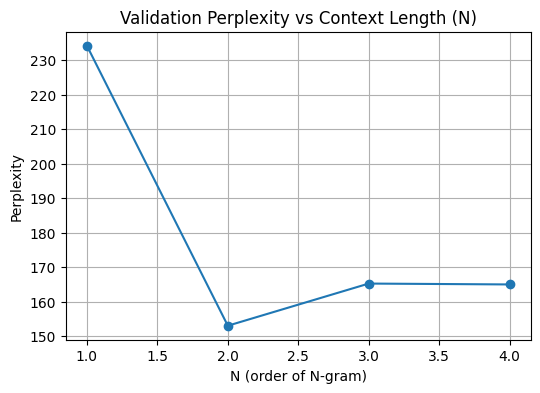

In [7]:

# Aggregate by N (k averaged) just for a simple line visualization
import numpy as np

by_n = {}
for n, k, ppl in results:
    by_n.setdefault(n, []).append(ppl)

ns = sorted(by_n.keys())
avg_ppl = [sum(by_n[n])/len(by_n[n]) for n in ns]

plt.figure(figsize=(6,4))
plt.plot(ns, avg_ppl, marker='o')
plt.title("Validation Perplexity vs Context Length (N)")
plt.xlabel("N (order of N-gram)")
plt.ylabel("Perplexity")
plt.grid(True)
plt.show()



## Exploration
We inspect the **next‑word distribution** for a given context and generate samples with different temperatures.


In [8]:

def show_topk_distribution(lm, context_tokens, k=10):
    dist = lm.distribution(context_tokens[-(lm.n-1):] if lm.n>1 else [])
    items = sorted(dist.items(), key=lambda x: x[1], reverse=True)[:k]
    print("Context:", " ".join(context_tokens[-(lm.n-1):]))
    for w, p in items:
        print(f"{w:>12s}  {p:.4f}")

context = tokenize("the children")
show_topk_distribution(chosen, context, k=12)

print("\nTemperature = 0.7")
print(chosen.sample(prompt=context, temperature=0.7, max_len=30))
print("\nTemperature = 1.0")
print(chosen.sample(prompt=context, temperature=1.0, max_len=30))
print("\nTemperature = 1.3")
print(chosen.sample(prompt=context, temperature=1.3, max_len=30))


Context: children
     marched  0.0180
         may  0.0060
 predictions  0.0060
     becomes  0.0060
         hot  0.0060
         was  0.0060
      lovely  0.0060
   hesitated  0.0060
      folded  0.0060
         new  0.0060
          do  0.0060
  complexion  0.0060

Temperature = 0.7
the children bloomed was his potions keyhole readers children smooth bottle lovely eye spring was are like stones potions dimmed hills predictions hills tables still we hedges measure saw stories unusual around

Temperature = 1.0
the children the keyhole glowed moon bookmarks thou shake day time

Temperature = 1.3
the children hath folded potions tales sprinkled potions stories his books table table painted summer’s and bloomed dimmed in lamps brass drink whispered evidence band why curious were potions lovely . heaven


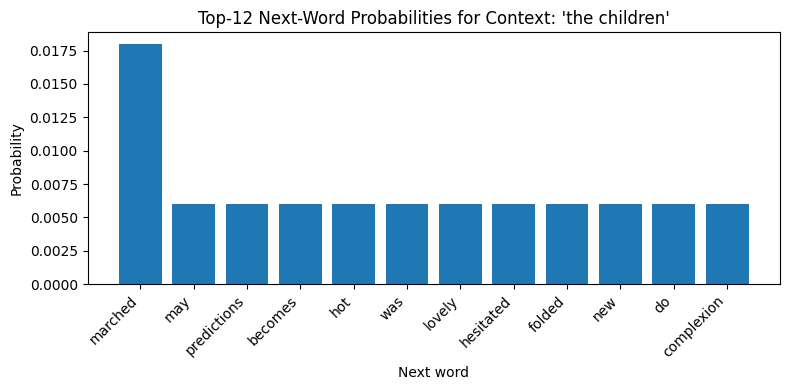

In [9]:

# Bar chart for next-word distribution (top 12)
dist = chosen.distribution(context[-(chosen.n-1):] if chosen.n>1 else [])
items = sorted(dist.items(), key=lambda x: x[1], reverse=True)[:12]
words = [w for w,_ in items]
probs = [p for _,p in items]

plt.figure(figsize=(8,4))
plt.bar(words, probs)
plt.title("Top-12 Next-Word Probabilities for Context: 'the children'")
plt.xlabel("Next word")
plt.ylabel("Probability")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



## Analysis & Discussion
- **Perplexity & Context (RQ1):** We examine how adding context (larger N) lowers perplexity on held‑out text. In small corpora, gains may plateau quickly due to data sparsity.  
- **Smoothing (RQ2):** Higher `k` increases probability mass for unseen events (helpful for robustness) but can raise perplexity slightly.  
- **Temperature (RQ3):** Lower temperatures sharpen distributions (safer, repetitive); higher temperatures flatten them (more diverse, riskier).  
- **Limitations (RQ4):** The N‑gram LM cannot track long‑range structure, factual knowledge, or complex syntax as reliably as Transformers. It also struggles with open‑vocabulary issues and compounding sparsity for large N.

### Ethical Considerations
- **Bias & Fairness:** Even simple LMs mirror biases in data. Curate corpora and audit outputs.  
- **Transparency:** Report data composition and training choices.  
- **Safety:** Avoid generating harmful or personal data; add filters or constraints if deploying.  
- **Reproducibility:** Seed randomness and document preprocessing.



## Relation to Modern LMs (GPT/BERT)
- **GPT‑style** autoregressive Transformers model the full left‑to‑right distribution with **self‑attention** and can capture far longer contexts than N‑grams.  
- **BERT** is a **masked‑language model** trained bidirectionally for representation learning; it excels at understanding tasks (classification, QA) but is not a generative LM in the same way.  
- Despite scale differences, **core metrics** (like perplexity) and **sampling controls** (like temperature) remain conceptually connected across LM families.



## Conclusion & Future Work
**Findings:** On this corpus, increasing N from 1→3 typically lowers perplexity; smoothing and temperature shape robustness vs creativity.  
**Future Work:**  
- Add **Kneser–Ney** or **interpolated backoff** smoothing.  
- Scale to larger **domain‑specific corpora** and compare to small pretrained Transformers.  
- Add **evaluation tasks** (cloze tests, coherence judgments).  
- Integrate **toxicity / bias** checks and data statements.

**Takeaway:** Even a compact N‑gram LM offers a clear window into LM fundamentals and a strong didactic baseline for understanding GPT‑class models.



## How to Use
- Run all cells top‑to‑bottom.
- Adjust `N` and `k` in the training cell; change `context` and `temperature` in the exploration section.
- Replace `corpus_text` with your own dataset to adapt to different domains.
